In [6]:
text ='Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in "memory" about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each characters appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'

Training with sequence length: 10
Epoch 1, Train Loss: 2.5887701511383057, Validation Loss: 2.6076791286468506, Time: 0.34290194511413574s
Epoch 2, Train Loss: 2.584566116333008, Validation Loss: 3.3199379444122314, Time: 0.3453385829925537s
Epoch 3, Train Loss: 3.1807825565338135, Validation Loss: 3.191694974899292, Time: 0.5103063583374023s
Epoch 4, Train Loss: 3.1782844066619873, Validation Loss: 2.708423376083374, Time: 0.6241424083709717s
Epoch 5, Train Loss: 2.6968636512756348, Validation Loss: 2.407820701599121, Time: 0.7037816047668457s
Epoch 6, Train Loss: 2.375554084777832, Validation Loss: 2.546438217163086, Time: 0.5731263160705566s
Epoch 7, Train Loss: 2.495755910873413, Validation Loss: 2.3998162746429443, Time: 0.47450995445251465s
Epoch 8, Train Loss: 2.4003677368164062, Validation Loss: 2.290980100631714, Time: 0.5621480941772461s
Epoch 9, Train Loss: 2.293236494064331, Validation Loss: 2.235318183898926, Time: 0.5028815269470215s
Epoch 10, Train Loss: 2.23696208000183

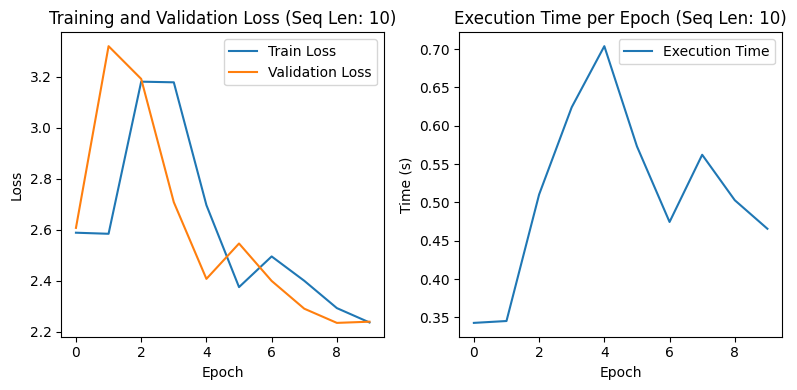

Training with sequence length: 20
Epoch 1, Train Loss: 2.743166208267212, Validation Loss: 2.8537120819091797, Time: 0.2466437816619873s
Epoch 2, Train Loss: 2.7289583683013916, Validation Loss: 2.6665635108947754, Time: 0.29415392875671387s
Epoch 3, Train Loss: 2.5996434688568115, Validation Loss: 2.2341017723083496, Time: 0.3390827178955078s
Epoch 4, Train Loss: 2.2721140384674072, Validation Loss: 2.004497766494751, Time: 0.31205248832702637s
Epoch 5, Train Loss: 2.048339605331421, Validation Loss: 2.1149580478668213, Time: 0.37323927879333496s
Epoch 6, Train Loss: 2.0978901386260986, Validation Loss: 1.9516520500183105, Time: 0.3775506019592285s
Epoch 7, Train Loss: 1.915676236152649, Validation Loss: 1.8142355680465698, Time: 0.34659838676452637s
Epoch 8, Train Loss: 1.8234338760375977, Validation Loss: 1.7874890565872192, Time: 0.4077572822570801s
Epoch 9, Train Loss: 1.822524905204773, Validation Loss: 1.8252578973770142, Time: 0.3763003349304199s
Epoch 10, Train Loss: 1.8805989

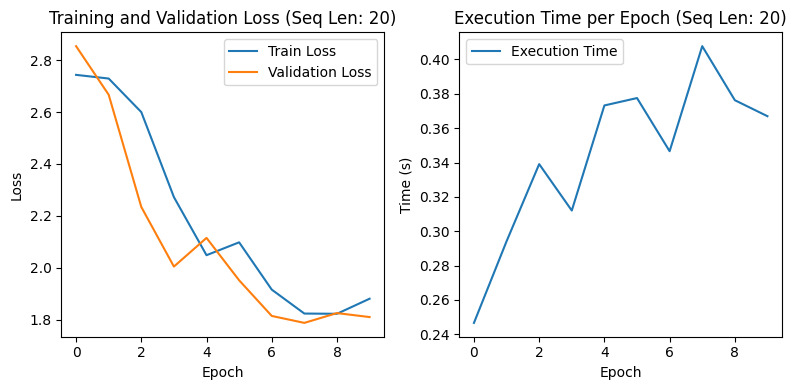

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time

class CharacterDataset(Dataset):
    def __init__(self, text, sequence_length=10):
        self.text = text
        self.sequence_length = sequence_length
        self.characters = sorted(list(set(text)))
        self.char_to_idx = {ch: idx for idx, ch in enumerate(self.characters)}
        self.idx_to_char = {idx: ch for idx, ch in enumerate(self.characters)}

    def __len__(self):
        return max(0, len(self.text) - self.sequence_length)

    def __getitem__(self, index):
        inputs = self.text[index:index + self.sequence_length]
        targets = self.text[index + 1:index + self.sequence_length + 1]
        input_indices = torch.tensor([self.char_to_idx[ch] for ch in inputs], dtype=torch.long)
        target_indices = torch.tensor([self.char_to_idx[ch] for ch in targets], dtype=torch.long)
        return input_indices, target_indices

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)]

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_decoder_layers=3, dim_feedforward=2048):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, self.d_model)
        self.pos_encoder = PositionalEncoding(self.d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(self.d_model, nhead, dim_feedforward),
            num_decoder_layers
        )
        self.fc_out = nn.Linear(self.d_model, vocab_size)

    def forward(self, src):
        src = self.embedding(src) * np.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_decoder(src, src)
        return self.fc_out(output)

def train(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    for inputs, targets in (data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    duration = time.time() - start_time
    return total_loss / len(data_loader), duration

def validate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))
            total_loss += loss.item()
    return total_loss / len(data_loader)

def main():
    text = "Here is a simple example."
    sequence_lengths = [10, 20, 30]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}

    for seq_len in sequence_lengths:
        if seq_len >= len(text):
            continue
        print(f"Training with sequence length: {seq_len}")
        dataset = CharacterDataset(text, sequence_length=seq_len)
        data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        model = TransformerModel(vocab_size=len(dataset.characters)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_losses, times = [], [], []
        epochs = 10
        for epoch in range(epochs):
            train_loss, epoch_time = train(model, data_loader, optimizer, criterion, device)
            val_loss = validate(model, data_loader, criterion, device)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            times.append(epoch_time)
            print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Time: {epoch_time}s')

        results[seq_len] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'times': times
        }
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Training and Validation Loss (Seq Len: {seq_len})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(times, label='Execution Time')
        plt.title(f'Execution Time per Epoch (Seq Len: {seq_len})')
        plt.xlabel('Epoch')
        plt.ylabel('Time (s)')
        plt.legend()

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()
